In [3]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin

from sentence_transformers import SentenceTransformer, models


In [4]:
base_dir = os.getcwd()
train_path = os.path.join(base_dir, "../data/train_data.csv")
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df["label"] = (train_df["label"] > 0.4).astype(int)
test_df["isHate"] = (test_df["isHate"] > 0.4).astype(int)

train_texts = train_df["text"].astype(str).tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].astype(str).tolist()
test_labels = test_df["isHate"].tolist()


In [5]:
class NaiveBayesHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2',
                 precomputed=False, use_hatebert=False):
        self.threshold = threshold
        self.model_name = model_name
        self.precomputed = precomputed
        self.use_hatebert = use_hatebert

        self.scaler = StandardScaler()
        self.model = GaussianNB()

        if use_hatebert:
            word_model = models.Transformer("GroNLP/hateBERT")
            pooling_model = models.Pooling(word_model.get_word_embedding_dimension())
            self.embedder = SentenceTransformer(modules=[word_model, pooling_model])
        else:
            self.embedder = SentenceTransformer(model_name)

    def fit(self, X, y):
        if self.precomputed:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_emb = self.get_embeddings(X, scale=True)
            X_scaled = X_emb
        self.model.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        if self.precomputed:
            X_scaled = self.scaler.transform(X)
        else:
            X_emb = self.get_embeddings(X, scale=True)
            X_scaled = X_emb
        return self.model.predict_proba(X_scaled)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == np.array(y))
    
    def get_embeddings(self, texts, scale=True, batch_size=32):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        embeddings = self.embedder.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return self.scaler.fit_transform(embeddings) if scale else embeddings

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Hate", "Hate"],
                    yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def show_misclassifications(self, X, y_true, y_pred):
        X = pd.Series(X)
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)
        mismatches = X[y_true != y_pred]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))
        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))

    def plot_roc_curve(self, X, y_true):
        probs = self.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - Naive Bayes Hate Speech Classifier")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Test Accuracy: 0.6673


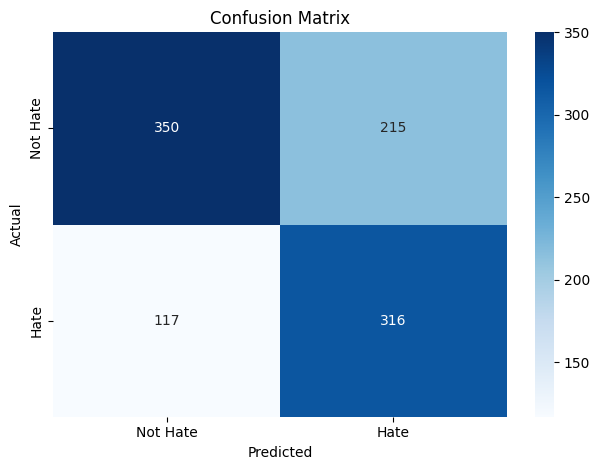

Batches: 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


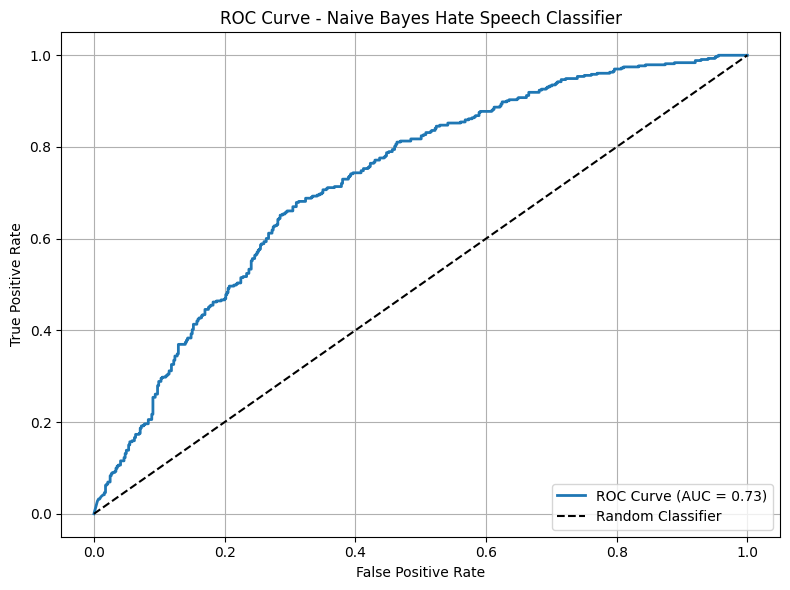


FALSE POSITIVES:
men and women are not equal.  irrational contra...
You can ask me to call you a male, but you'll a...
Yo, if I’m going to hell for being homosexual, ...
     White police officers are always the victims.
Well..congratulations u loose one of ur subscri...

FALSE NEGATIVES:
why does that african american monkey hold gun ...
Who do you think you are cunt? wtf! Stay steady...
Watching this kid trying to step up and walk wi...
Throwing stones to paraplegic kids is my favour...
This priest is being hated even by his stupid g...


In [ ]:
model = NaiveBayesHateSpeechClassifier(use_hatebert=True)
model.fit(train_texts, train_labels)
y_pred = model.predict(test_texts)
print(f"Test Accuracy: {model.score(test_texts, test_labels):.4f}")
model.plot_confusion_matrix(test_labels, y_pred)
model.plot_roc_curve(test_texts, test_labels)
model.show_misclassifications(test_texts, test_labels, y_pred)
